# LSTM and Bidirectional LSTM Model Pipeline
**MIDS W210 Capstone | Find Your Rhythm**

Test Example: 
* raw-audio/eGMD/eGMD-wavfiles/drummer1_eval_session_4_soul-groove4_80_beat_4-4_24.midi.wav
* raw-audio/eGMD/eGMD-wavfiles/drummer1_session1_82_neworleans-funk_84_beat_4-4_4.midi.wav
* raw-audio/eGMD/eGMD-wavfiles/drummer1_eval_session_7_pop-groove7_138_beat_4-4_10.midi.wav

Model:
Trained by mdb_idmt_egmd1000

In [1]:
from google.cloud import storage

# Basic packages 
import pickle
import librosa
import IPython.display as ipd
import numpy as np
from os import listdir
import os
import sys
import math
import random

# Plot Package
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import clear_output

# Model Package
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Activation,LSTM, TimeDistributed, Bidirectional
from keras.regularizers import l2
from keras import callbacks
from keras.callbacks import History, ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report

## 1. Audio Play

In [4]:
sys.path.append('find-your-rhythm-gcp/progs')
from utility_functions import *

auth_json = 'Find Your Rhythm-57160f79f377.json'
bucket_name = 'fyr-audio-data'
gcp_filepath = 'raw-audio/eGMD/eGMD-wavfiles/drummer1_eval_session_7_pop-groove7_138_beat_4-4_10.midi.wav'

egmd_wav3 = readGcpWav(auth_json, bucket_name, gcp_filepath, sr=22050)
ipd.Audio(egmd_wav3, rate=22050)

In [49]:
librosa.time_to_frames(27)

1162

## 2: data pipeline with model trained using fit
Model: trained by mdb_idmt_egmd1000 dataset

**Predict Labels Using BiLSTM Model**
1. Predict onset probability using BiLSTM Model with outcome size (batch size, segment length, no of instruments) using KerasSegmentGenerator
2. Concatecate all batches into one song with size of (number of frames, no of instruments)
3. Peak pick method: evaluate onset with predicted outcomes at each frame for each instrument based on pick peak method

In [5]:
class KerasSegmentGenerator(object):
    def __init__(self, data, num_steps, num_features, skip_step=5):
        self.data = data  #Train, validation, test dataset
        self.num_steps = num_steps  # segment length
        self.num_features = num_features # no of feature bins
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idx = 0  # track progress of batches, once dataset reaches the end, it resets to zero
        # THis determines overlap for two sequential segment, if skip step = num step, there is no overlap
        self.skip_step = skip_step

    def generate(self):
        """Output Train and Validation Dataset and Labels
        Train Dataset Dimentsion: Batch Size, Segment Length, no of frequency bin
        Train Label Dimension: Batch Size, Segment Length, no of drum instrument"""
        self.interations = int(len(self.data)/self.num_steps)
        self.x = np.zeros((self.interations, self.num_steps, self.num_features))
        
        while True:
            for i in range(self.interations):
                if self.current_idx + self.num_steps >= len(self.data):
                  # reset the index back to the start of the data set
                   self.current_idx = 0
                self.x[i, :, :] = self.data[self.current_idx:self.current_idx + self.num_steps]
                self.current_idx += self.skip_step
            return self.x

In [14]:
def preprocessor(file, sr=22050, hop_length=512, seg_len=5, representation='stft'):
    """
    Preprocesing steps for raw data file transformation into model input.
    """
    # convert segmentLength in second into integer if a float value is provided
    segment_length = int(seg_len)
    # load the wav file into an audio time series array
    wav = file
    # length of the full wav array
    wav_len = len(wav)
    # create an array representation of the wav audio data
    if representation == 'stft':
        # transpose the stft array so that rows represent each frame in time and features (columns) are frequency bins
        data = np.absolute(librosa.stft(wav)).transpose()
    elif representation == 'cqt':
        # transpose the cqt array so that rows represent each frame in time and features (columns) are frequency bins
        data = np.absolute(librosa.cqt(wav, sr=sr)).transpose()
    # pad the end of the audio with silence depending on the sequence length
    number_frames = data.shape[0]
    # Transfer segment length in sec to segment length in frame
    segmentLength = librosa.time_to_frames(segment_length, sr=sr)
    # calculate how much silence should be added in last segment
    remaining_frames = int(segmentLength-(number_frames % segmentLength))
    # if the audio can not fill the frames of last segment, silence is padded on to the end of the segment
    if remaining_frames != segmentLength:
        # attach zeros to the end of row of stft to make sure two songs are not merged within one segment 
        data = np.append(data,np.zeros((remaining_frames, data.shape[1])),axis=0)
    arr_out = np.asarray(data)
    #Model transformations 
    segment_generator = KerasSegmentGenerator(arr_out, segmentLength, arr_out.shape[1], skip_step=segmentLength)
    model_data = segment_generator.generate()
    return model_data  

**Check Training Data Labels Index**

In [15]:
file_name = 'labels.pkl'
VM_folder = 'model_input/mdb_idmt_egmd1000/'
gcp_folder='model_inputs/mdb_idmt_egmd1000/'
with open(VM_folder + file_name, 'rb') as file:
    dict_keys = pickle.load(file)
print(dict_keys)

[38, 35, 51, 42, 44, 37, 50, 43, 46, 54, 53, 49, 47, 39, 41, 56, 48, 52, 55]


In [16]:
# Instrument pitch is ordered based on label counts collected in mdb and idmt database
midi_classes = {35: 'Acoustic Bass Drum', 36: 'Bass Drum 1', 37: 'Side Stick', 38: 'Acoustic Snare', 39: 'Hand Clap', 
                40: 'Electric Snare', 41: 'Low Floor Tom', 42: 'Closed Hi Hat', 43: 'High Floor Tom', 44: 'Pedal Hi-Hat', 
                45: 'Low Tom', 46: 'Open Hi-Hat', 47: 'Low-Mid Tom', 48: 'Hi-Mid Tom', 49: 'Crash Cymbal 1', 
                50: 'High Tom',  51: 'Ride Cymbal 1', 52: 'Chinese Cymbal', 53: 'Ride Bell', 54: 'Tambourine', 
                55: 'Splash Cymbal', 56: 'Cowbell', 57: 'Crash Cymbal 2', 58: 'Vibraslap', 59: 'Ride Cymbal 2', 
                60: 'Hi Bongo', 61: 'Low Bongo', 62: 'Mute Hi Conga', 63: 'Open Hi Conga', 64: 'Low Conga', 
                65: 'High Timbale', 66: 'Low Timbale', 67: 'High Agogo', 68: 'Low Agogo', 69: 'Cabasa', 
                70: 'Maracas', 71: 'Short Whistle', 72: 'Long Whistle', 73: 'Short Guiro', 74: 'Long Guiro', 
                75: 'Claves', 76: 'Hi Wood Block', 77: 'Low Wood Block', 78: 'Mute Cuica', 79: 'Open Cuica', 
                80: 'Mute Triangle', 81: 'Open Triangle',
               # to be removed
                22: 'Unknown 22', 26: 'Unknown 26'
               }

inst_labels = []
for inst_t in dict_keys:
    inst_labels.append(midi_classes[inst_t])
print(inst_labels)

['Acoustic Snare', 'Acoustic Bass Drum', 'Ride Cymbal 1', 'Closed Hi Hat', 'Pedal Hi-Hat', 'Side Stick', 'High Tom', 'High Floor Tom', 'Open Hi-Hat', 'Tambourine', 'Ride Bell', 'Crash Cymbal 1', 'Low-Mid Tom', 'Hand Clap', 'Low Floor Tom', 'Cowbell', 'Hi-Mid Tom', 'Chinese Cymbal', 'Splash Cymbal']


**Preprocess Data**

In [17]:
testx = preprocessor(egmd_wav3, sr=22050, hop_length=512, seg_len=5, representation='stft')
print(testx.shape)

(6, 215, 1025)


**Use function Pred_Segment to predict onset with preprocessed audio input**

In [18]:
# Model Filepath
File_Root = 'model_log/'
database_name = 'mdb_idmt_egmd1000'
number_units = 500
number_layers = 2
number_classes = 13
num_epochs = 200
batch_size = 40

#Create a folder to restore the state and log file
weights_dir = File_Root + 'BiLSTM_%s_BatchSize_%i_Layers_%i_Nodes_%i_Classes_%i'%(database_name, batch_size, number_layers, number_units, number_classes)
modelname = "/model-29.hdf5"
model_filepath_M2 = weights_dir + modelname

In [19]:
def Pred_Segment(file, threshold, testx = testx):
    """
    Predict onset probability and evaluate onset point based on peak pick method
    """
    model = load_model(file)
    prediction = model.predict(testx)


    for i in range(prediction.shape[0]):
        if i == 0:
            prediction_concat = prediction[i, :, :]

        else:
            prediction_concat = np.concatenate((prediction_concat,prediction[i, :, :]))


    T= threshold
    predicts =  np.zeros(prediction_concat.shape)
    for i in range(prediction_concat.shape[0]):
        for j in range(prediction_concat.shape[1]):
            if (i != 0) and (i != prediction_concat.shape[0]-1):
                if (prediction_concat[i][j]>prediction_concat[i-1][j]) and (prediction_concat[i][j]>=prediction_concat[i+1][j]) and (prediction_concat[i][j]>T[j]):
                    predicts[i][j] = 1
                else:
                    predicts[i][j] = 0
            else:
                predicts[i][j] = 0
    return predicts
    

In [21]:
threshold_M2 = [0.6989163, 0.6494368, 0.4516095,0.5138468,0.3561319,0.18814914,0.08019187,0.08303985, 0.04963303, 0.00304278, 0.01629751, 0.01467455, 0.00192047]
predicts_V3 = Pred_Segment(model_filepath_M2, threshold_M2)

**Plot Onset**

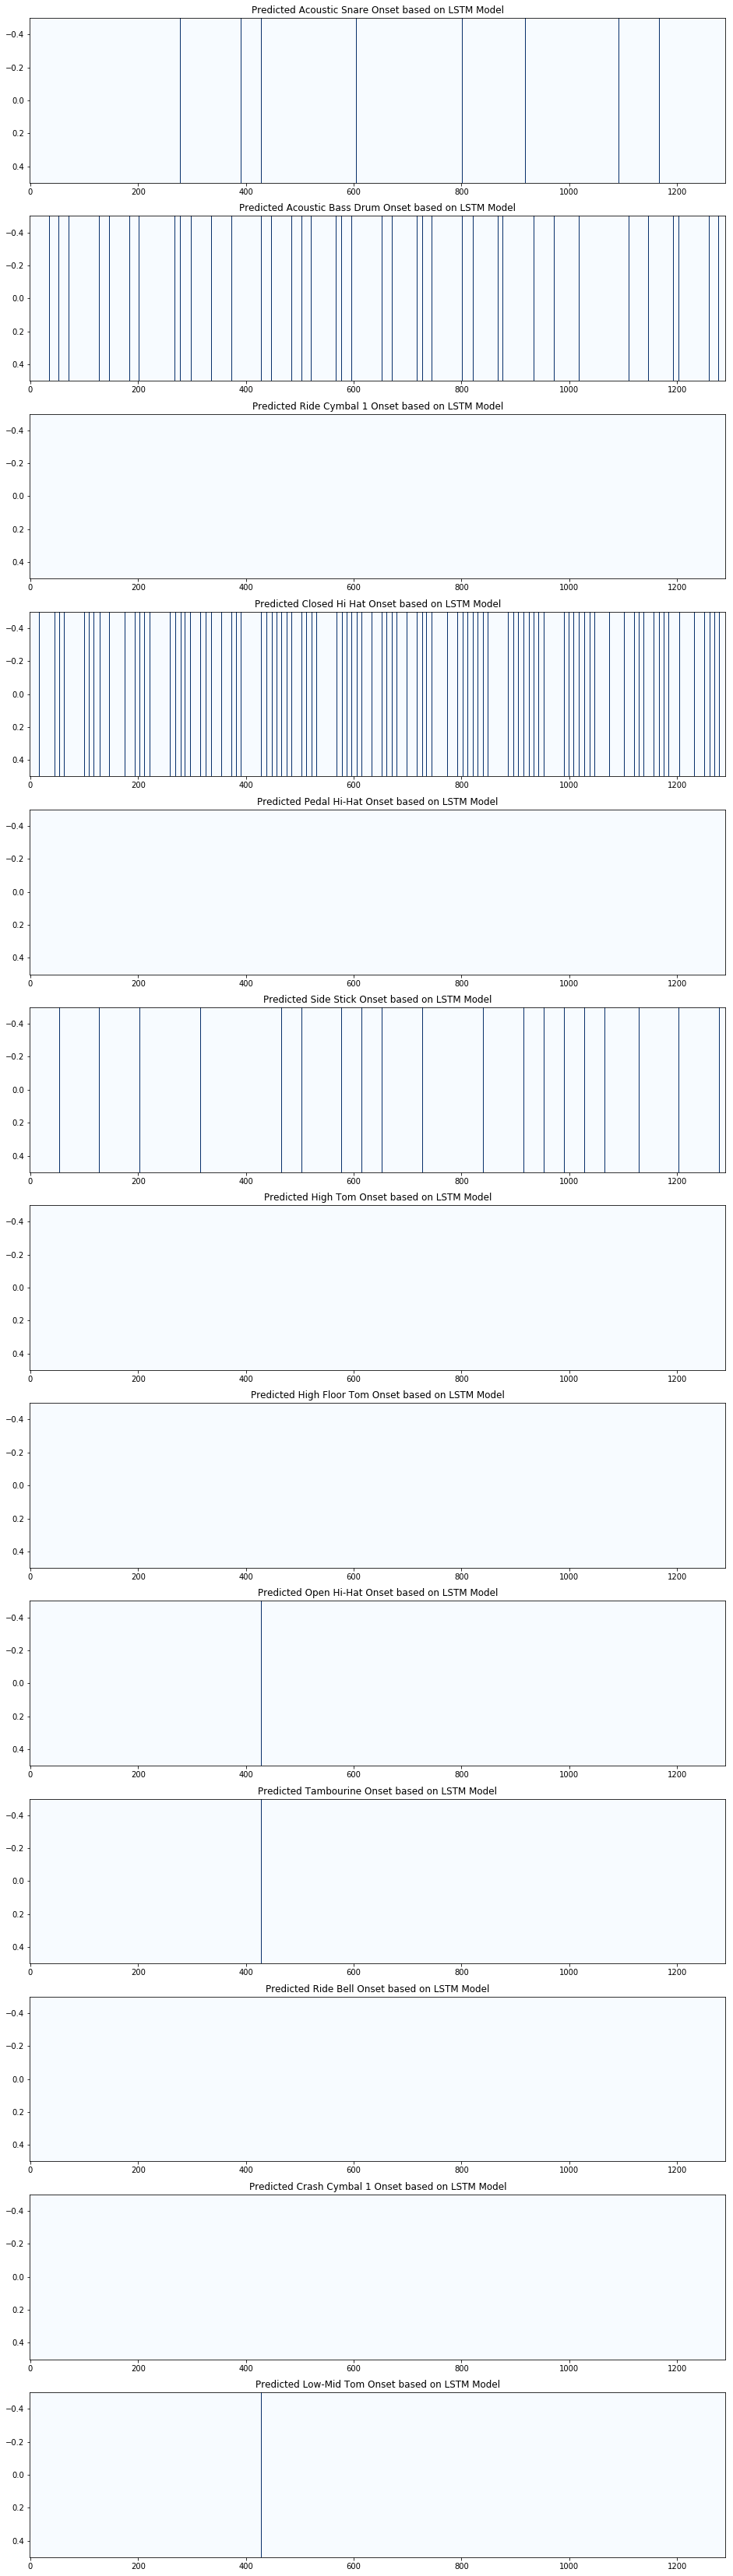

In [22]:
fig, axes = plt.subplots(number_classes,1, figsize=(16,60))

for ints_idx in range(number_classes):
    axes[ints_idx].set_title('Predicted %s Onset based on LSTM Model'% (inst_labels[ints_idx]))
    axes[ints_idx].imshow(predicts_M2[0:,ints_idx:ints_idx+1].transpose(),cmap='Blues',aspect='auto', interpolation = 'nearest')
# axes[2].set_xticklabels(range(4950,5250,50))

## 3: Load Test Data and Lables
Model: trained by mdb_idmt_egmd1000 dataset


In [23]:
def loadfile(bucket, gcp_filepath, VM_filepath):
    """
    Loads n a np file from GCP bucket storage to VM
    
    Inputs:
    bucket = str bucket name
    gcp_filepath = filepath to file in bucket
    VM_filepath = filepath in VM to store np data
    
    """
    from google.cloud import storage
    import pickle as pkl
    
    # create storage client
    storage_client = storage.Client()
    # get bucket with name
    bucket = storage_client.get_bucket(bucket)
    # get bucket data as blob
    blob = bucket.blob(gcp_filepath)
    
    with open(VM_filepath, "wb") as dest_file:
        blob.download_to_file(dest_file)
        


In [25]:
def loadArrays(dataset='train', bucket=None, gcp_folder=None, VM_folder=None, LoadFile=False):
    """
    Inputs:
    dataset = 'train', 'val', or 'test'

    Outputs:
    arr_x = input data
    arr_y = input labels
    arr_dict = lookup dict {initial frame : song name}
    """

    datasets = {'train':['train_x.npy','train_y.npy','train_dict.pkl'],
              'val':['val_x.npy','val_y.npy','val_dict.pkl'],
              'test':['test_x.npy','test_y.npy','test_dict.pkl']}
    
    if LoadFile == True:
        for i in range(len(datasets[dataset])):
            loadfile(bucket, gcp_folder + datasets[dataset][i], VM_folder + datasets[dataset][i])
            

    arr_x = np.load(VM_folder + datasets[dataset][0])
    arr_y = np.load(VM_folder + datasets[dataset][1])
    with open(VM_folder + datasets[dataset][2], 'rb') as file:
        arr_dict = pickle.load(file)
    

    return arr_x, arr_y, arr_dict

In [26]:
x_test, y_test, test_dict = loadArrays('test', bucket='fyr-audio-data', gcp_folder='model_inputs/mdb_idmt_egmd1000/', VM_folder='model_input/mdb_idmt_egmd1000/')

In [48]:
x_test.shape

(94385, 1025)

In [27]:
test_dict

{0: 'raw-audio/eGMD/eGMD-wavfiles/drummer1_session1_177_afrocuban_105_fill_4-4_55.midi.wav',
 215: 'raw-audio/eGMD/eGMD-wavfiles/drummer1_session1_150_latin-brazilian-baiao_95_fill_4-4_52.midi.wav',
 430: 'raw-audio/eGMD/eGMD-wavfiles/drummer1_session1_39_latin-samba_116_fill_4-4_34.midi.wav',
 645: 'raw-audio/eGMD/eGMD-wavfiles/drummer1_session1_237_rock-halftime_140_fill_4-4_58.midi.wav',
 860: 'raw-audio/eGMD/eGMD-wavfiles/drummer1_session1_262_funk-purdieshuffle_130_fill_4-4_3.midi.wav',
 1075: 'raw-audio/eGMD/eGMD-wavfiles/drummer1_session1_210_rock-halftime_140_fill_4-4_19.midi.wav',
 1290: 'raw-audio/eGMD/eGMD-wavfiles/drummer1_session2_15_country_114_fill_4-4_42.midi.wav',
 1505: 'raw-audio/eGMD/eGMD-wavfiles/drummer1_session1_195_reggae_78_fill_4-4_18.midi.wav',
 1720: 'raw-audio/eGMD/eGMD-wavfiles/drummer1_session2_137_afrocuban-bembe_122_fill_4-4_11.midi.wav',
 3870: 'raw-audio/eGMD/eGMD-wavfiles/drummer1_eval_session_4_soul-groove4_80_beat_4-4_23.midi.wav',
 8170: 'raw-audi

In [28]:
class KerasSegmentGenerator(object):
    def __init__(self, data, outcome, num_steps, num_features, num_class, skip_step=5):
        self.data = data  #Train, validation, test dataset
        self.outcome = outcome #Train, validation, test labels
        self.num_steps = num_steps  # segment length
        self.num_features = num_features # no of feature bins
        self.num_class = num_class  # no of different Drum Instruments (3 DIs)
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idx = 0  # track progress of batches, once dataset reaches the end, it resets to zero
        # THis determines overlap for two sequential segment, if skip step = num step, there is no overlap
        self.skip_step = skip_step

    def generate(self):
        """Output Train and Validation Dataset and Labels
        Train Dataset Dimentsion: Batch Size, Segment Length, no of frequency bin
        Train Label Dimension: Batch Size, Segment Length, no of drum instrument"""
        self.interations = int(len(self.data)/self.num_steps)
        self.x = np.zeros((self.interations, self.num_steps, self.num_features))
        self.y = np.zeros((self.interations, self.num_steps, self.num_class))
        
        while True:
            for i in range(self.interations):
                if self.current_idx + self.num_steps >= len(self.data):
                  # reset the index back to the start of the data set
                   self.current_idx = 0
                self.x[i, :, :] = self.data[self.current_idx:self.current_idx + self.num_steps]
                self.y[i, :, :] = self.outcome[self.current_idx:self.current_idx + self.num_steps]
                self.current_idx += self.skip_step
            return self.x, self.y

In [29]:
# npy arrays were created using segment length of 5 seconds
# convert 5 seconds into frames (npy arrays are in frames)
segmentLength = librosa.time_to_frames(5) 

# Number of drum instruments to study in model
n_inst = 13

test_segment_generator = KerasSegmentGenerator(x_test , y_test[:,0:n_inst], segmentLength, x_test.shape[1], y_test[:,0:n_inst].shape[1],
                                           skip_step=segmentLength)


testx,testy = test_segment_generator.generate()

print('Test dataset shape:', testx.shape)
print('Test label shape:', testy.shape)

Test dataset shape: (439, 215, 1025)
Test label shape: (439, 215, 13)


In [32]:
database_name = 'mdb_idmt_egmd1000'
number_units = 500
number_layers = 2
number_classes = n_inst
num_epochs = 200
batch_size = 40

#Create a folder to restore the state and log file
weights_dir = File_Root + 'BiLSTM_%s_BatchSize_%i_Layers_%i_Nodes_%i_Classes_%i'%(database_name, batch_size, number_layers, number_units, number_classes)

model = load_model(weights_dir + "/model-29.hdf5")

prediction = model.predict(testx)


for i in range(prediction.shape[0]):
    if i == 0:
        prediction_concat = prediction[i, :, :]
        testy_concat = testy[i, :, :]
    else:
        prediction_concat = np.concatenate((prediction_concat,prediction[i, :, :]))
        testy_concat = np.concatenate((testy_concat,testy[i, :, :]))
        


t = [20]


T = t*np.mean(prediction_concat,axis = 0)
predicts =  np.zeros(prediction_concat.shape)
print(T)
for i in range(prediction_concat.shape[0]):
    for j in range(prediction_concat.shape[1]):
        if (i != 0) and (i != prediction_concat.shape[0]-1):
            if (prediction_concat[i][j]>prediction_concat[i-1][j]) and (prediction_concat[i][j]>=prediction_concat[i+1][j]) and (prediction_concat[i][j]>T[j]):
                predicts[i][j] = 1
            else:
                predicts[i][j] = 0
        else:
            predicts[i][j] = 0



from sklearn.metrics import classification_report
print(classification_report(testy_concat, predicts, target_names=inst_labels[0:n_inst]))

[0.69891632 0.64943679 0.45160949 0.5138468  0.3561319  0.18814914
 0.08019187 0.08303985 0.04963303 0.00304278 0.01629751 0.01467455
 0.00192047]
                    precision    recall  f1-score   support

    Acoustic Snare       0.98      0.89      0.93      3379
Acoustic Bass Drum       0.98      0.97      0.98      3062
     Ride Cymbal 1       1.00      0.99      0.99      2141
     Closed Hi Hat       0.91      0.84      0.87      2407
      Pedal Hi-Hat       0.97      0.98      0.97      1633
        Side Stick       0.98      0.95      0.97       932
          High Tom       0.96      0.97      0.97       385
    High Floor Tom       0.96      0.98      0.97       389
       Open Hi-Hat       0.63      0.73      0.67       298
        Tambourine       0.07      1.00      0.13        13
         Ride Bell       0.59      0.97      0.74        80
    Crash Cymbal 1       0.55      0.88      0.67        73
       Low-Mid Tom       0.02      1.00      0.03         5

       avg 

In [43]:
def Extract_Pred(audio_name, predicts = predicts, testy_concat=testy_concat):     
    key_list = list(test_dict.keys()) 
    val_list = list(test_dict.values()) 
    start_frame = key_list[val_list.index(audio_name)]
    key_list.sort()
    end_frame = key_list[key_list.index(start_frame)+1]
    print(start_frame)
    print(end_frame)
    predicts_test = predicts[start_frame:end_frame]
    true_labels = testy_concat[start_frame:end_frame]
    return predicts_test, true_labels

In [44]:
predicts_test_V3, true_labels_V3 = Extract_Pred('raw-audio/eGMD/eGMD-wavfiles/drummer1_eval_session_7_pop-groove7_138_beat_4-4_10.midi.wav')

87075
87505


In [46]:
print(librosa.time_to_frames(87505-87075))

18518


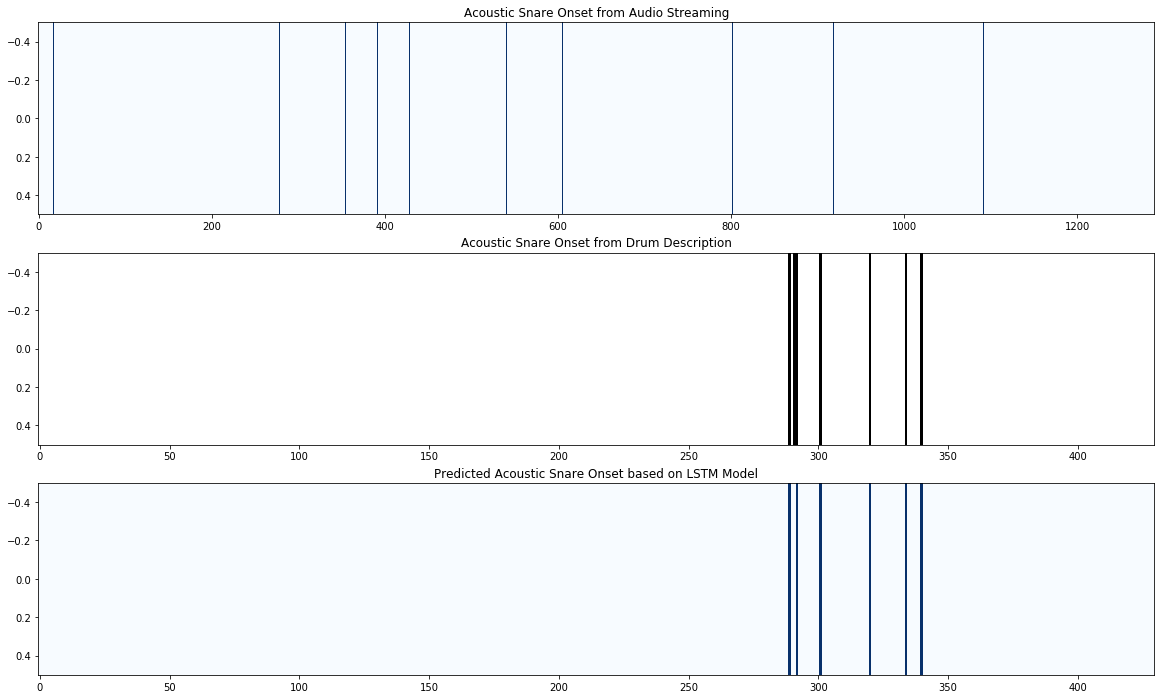

In [45]:
fig, axes = plt.subplots(3,1, figsize=(20,12))

ints_idx = 0

axes[0].set_title('%s Onset from Audio Streaming'% (inst_labels[ints_idx]))
axes[0].imshow(predicts_V3[:,ints_idx:ints_idx+1].transpose(),cmap='Blues',aspect='auto', interpolation = 'nearest')


axes[1].set_title('%s Onset from Drum Description'% (inst_labels[ints_idx]))
axes[1].imshow(true_labels_V3[:,ints_idx:ints_idx+1].transpose(),cmap='Greys',aspect='auto', interpolation = 'nearest')

axes[2].set_title('Predicted %s Onset based on LSTM Model'% (inst_labels[ints_idx]))
axes[2].imshow(predicts_test_V3[:,ints_idx:ints_idx+1].transpose(),cmap='Blues',aspect='auto', interpolation = 'nearest')


5.209856630824372


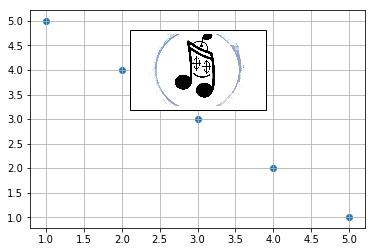

In [19]:
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, ax = plt.subplots()

ax.scatter([1,2,3,4,5],[5,4,3,2,1], alpha=1.0)

xmin, xmax, ymin, ymax = plt.axis()
print(xmax)

arr_lena = mpimg.imread('capture2.png')

imagebox = OffsetImage(arr_lena, zoom=0.1)

ab = AnnotationBbox(imagebox, (3, 4))

ax.add_artist(ab)

plt.grid()

plt.show()
